In [36]:
import numpy as np
import os
import json
import sys
import matplotlib.pyplot as plt
import skimage

sys.path.append("../")
import src.plot as myplot
import seaborn as sns

import sklearn
import scipy.stats as stats

In [37]:
import importlib
import src.plot as myplot
importlib.reload(myplot)

<module 'src.plot' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/plot.py'>

In [38]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)

<module 'src.paper_utils' from '/Users/paulhosek/PycharmProjects/mcm/MCM_classifier/Classifier_1/mcm/paper_plots/../src/paper_utils.py'>

In [160]:
sample_sizes = [10, 100, 500,1000, 2000, 3000,4000,5000]
sample_sizes = [5423]
counts_samplesizes, mcms_samplesizes = utils.load_counts_mcm(sample_sizes, letter="", path_format="../data/OUTPUT/mcm/sample_sizes")
test_mcms, test_probs = utils.get_complete_testprobs(mcms_samplesizes,counts_samplesizes,sample_sizes,n_runs=2,smooth=True)

In [161]:
# can always only do distance between two
# probably want distance own vs other
# the mcm that maximises the distance is the one that is selected in the classifier

In [162]:
# # select a digit that is the "test image", the one that is shown to all
# # select the most indicative icc for own vs a test image of that category
# # NOTE: in real life we do not know what category the test image is from
# # cannot take most indicative icc
# all_byk = []
# sample_idx = 0
# run_idx = 0
# test_digit = 0 # we show a 0 to all mcm and see who has highest reponse
# # mcms_range = range(10)
# mcms_range = [3,]
# for mcm_idx in mcms_range:
#     digit_pair = [mcm_idx,test_digit] # own vs test digit
#     _, icc_data,dists = utils.distmap_from_testprobs(test_probs, test_mcms, digit_pair, mcm_idx, sample_idx,run_idx, return_iccdata=True,return_dists=True)
#     ord_distidcs = np.argsort(dists)[::-1]
#     by_k = np.cumprod(icc_data[ord_distidcs],axis=0)[:,:,digit_pair]
#     all_byk.append(by_k)

In [163]:

import importlib
import src.paper_utils as utils
importlib.reload(utils)
def adjust_power1overR(all_byk_pair, all_byk_modspin):
    return [all_byk_pair[i] ** 1/all_byk_modspin[i][:,None,None] for i in range(2)]

sample_idx = 0
run_idx = 0
# digit_pair = [3,5]
digit_pair = [0,1]

all_byk_pair, all_byk_modspin = utils.get_all_byk_pair(test_probs, test_mcms, digit_pair, sample_idx, run_idx,adjust_by_size=False)
_, nspin_diff, mods_long_short = utils.adjust_smaller_icc(all_byk_pair,all_byk_modspin,dont_adjust=True)
# all_byk_pair = adjust_power1overR(all_byk_pair, all_byk_modspin)



In [164]:
# find the ones that are misclassified at the largest sample size

# the images of index digit 0 that are misclassified at max k
misclassified_img0_idcs = np.argwhere(all_byk_pair[0][-1,:,0] < all_byk_pair[1][-1,:,0]) # misclassified img idx0
misclassified_img1_idcs = np.argwhere(all_byk_pair[0][-1,:,1] > all_byk_pair[1][-1,:,1]) # misclassified img idx1

misclf_idcs = [misclassified_img0_idcs, misclassified_img1_idcs]
# misclf = [all_byk_pair[i][:,misclf_idcs[i],:] for i in range(2)]
misclf_idcs[0].shape

# for mcm 0: get indices for images of digit 0 that have been misclassified # [11,24,26]
# for mcm 0: get indices for images of digit 1 that have been misclassified # [99]

# for mcm 1: also get those 4 digits
# then slice the probability over k for both mcm


idx_ord = np.argsort([all_byk_pair[i].shape[0] for i in range(2)])
idx_ord, [all_byk_pair[0].shape[0], all_byk_pair[1].shape[0]]


(array([0, 1]), [19, 32])

In [165]:
# 1. slice 4 arrays: for each mcm slice each digit
# make short longer to fit size of longer mcm by reprepeatablyeaditely appending the full mcm probabilities


def misclassified_trajec_singledig(all_byk_pair,misclf_idcs, digit_index):
    short_long = np.argsort([all_byk_pair[i].shape[0] for i in range(2)])
    nspin_diff = np.abs(np.diff([all_byk_pair[0].shape[0], all_byk_pair[1].shape[0]]))[0]


    mcm0_misc0 = all_byk_pair[0][:,misclf_idcs[digit_index],digit_index]
    mcm1_misc0 = all_byk_pair[1][:,misclf_idcs[digit_index],digit_index]

    misc_digi0 = [mcm0_misc0,mcm1_misc0]

    appendix_short = np.tile(all_byk_pair[short_long[0]][-1,misclf_idcs[digit_index],digit_index], (nspin_diff,1,1))
    mcm_short = np.squeeze(np.concatenate((misc_digi0[short_long[0]], appendix_short)))

    if short_long[0] == 1:
        out_misc_digi0 = np.stack([np.squeeze(misc_digi0[short_long[1]]),np.squeeze(mcm_short)]) # (mcm_idx, icc, image)
    else:
        out_misc_digi0 = np.stack([np.squeeze(mcm_short), np.squeeze(misc_digi0[short_long[1]])]) # (mcm_idx, icc, image)

    return out_misc_digi0



all_misc = [misclassified_trajec_singledig(all_byk_pair,misclf_idcs, digit_index) for digit_index in range(2)]


In [166]:
test = all_misc[0]
test.mean(axis=2)[:,:,None].shape


(2, 32, 1)

In [167]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def compute_mean_and_ci_loglog(data, confidence=0.95, degree=1):
    x = data[0, :, :]  # shape (27, 45)
    y = data[1, :, :]  # shape (27, 45)

    # Convert to log-log space
    log_x = np.log(x)
    log_y = np.log(y)

    # Determine common log-x values using the union of all log-x values and sort them
    common_log_x = np.sort(np.unique(log_x))

    # Fit polynomial and interpolate each line to the common log-x values
    interpolated_log_y = np.zeros((len(common_log_x), x.shape[1]))  # shape (len(common_log_x), 45)
    for i in range(x.shape[1]):
        coeffs = np.polyfit(log_x[:, i], log_y[:, i], degree)
        poly = np.poly1d(coeffs)
        interpolated_log_y[:, i] = poly(common_log_x)

    # Compute mean and standard error in log-log space
    mean_log_y = np.mean(interpolated_log_y, axis=1)
    se_log_y = np.std(interpolated_log_y, axis=1, ddof=1) / np.sqrt(interpolated_log_y.shape[1])

    # Compute the 95% confidence interval in log-log space
    h = se_log_y * norm.ppf((1 + confidence) / 2)
    ci_lower_log = mean_log_y - h
    ci_upper_log = mean_log_y + h

    # Convert back to original space
    common_x = np.exp(common_log_x)
    mean_y = np.exp(mean_log_y)
    ci_lower = np.exp(ci_lower_log)
    ci_upper = np.exp(ci_upper_log)

    return common_x, mean_y, ci_lower, ci_upper

# Example usage

# plt.figure(figsize=(10, 6))
# # data = np.random.rand(2, 27, 45)  # Replace this with your actual data


# common_x, mean_y, ci_lower, ci_upper = compute_mean_and_ci_loglog(data, degree=2)
# plt.fill_between(common_x, ci_lower, ci_upper, color='b', alpha=0.2, label='95% CI')
# plt.plot(common_x, mean_y, 'b-', label='Mean')


# plt.xlabel('X')
# plt.ylabel('Y')
# plt.xscale('log')
# plt.yscale('log')
# plt.title('Mean and 95% Confidence Interval in Log-Log Space')
# plt.legend()
# plt.autoscale(False)
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# plt.grid(True, which="both", ls="--")
# plt.show()


In [168]:
# # working here. trying to aggregate somehow. could do mean, ci, 2-3 example ones
# # FIXME, when comparing this to the image above, the means and errors seem wrong here
#     # this is because x and y coordinates are dependent on each other, if i take the mean over differnt images x's then its gonna be at different points
# fig, ax1 = plt.subplots()

# colors = myplot.get_list_fromcmap("tab10", N=10)

# for dig_i, data in enumerate(all_misc): # shape each (mcm_idx, icc, image)

#     common_x, mean_y, ci_lower, ci_upper = compute_mean_and_ci_loglog(data, degree=1)
#     plt.fill_between(common_x, ci_lower, ci_upper, color=colors[digit_pair[dig_i]], alpha=0.2, label='95% CI')
#     plt.plot(common_x, mean_y, 'k:', label=f"{digit_pair[dig_i]}")

#     for i in range(data.shape[2]):
#         x = data[0, :, i]
#         y = data[1, :, i]

#         plt.plot(x, y, color=colors[digit_pair[dig_i]], alpha=.1)
#         plt.plot(x[0], y[0], marker="o", color=colors[digit_pair[dig_i]], markersize=4)  # First point marker
#         plt.plot(x[-1], y[-1], marker="o", color=colors[digit_pair[dig_i]], markersize=4)  # Last point marker

#     # # for i in range(2):
#     # ax1.errorbar(mean[0],mean[1], xerr=confidence_interval[0], yerr=confidence_interval[1], fmt='-o', label=f"{digit_pair[dig_i]}", alpha=.2, color=colors[digit_pair[dig_i]])

# # plt.plot(res[0],res[1], color=colors[digit_pair[dig_i]],fmt="-o", label=f"{digit_pair[dig_i]}", alpha=.2)

# plt.ylabel(f"MCM {digit_pair[1]}")
# plt.xlabel(f"MCM {digit_pair[0]}")
# plt.legend(loc="upper left", bbox_to_anchor=(0.5, -0.15), ncol=2)
# plt.xscale("log")
# plt.yscale("log")

# plt.autoscale(False)
# plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

# plt.title(f"Trajectory for misclassified images at max MCM over k")
# plt.show()

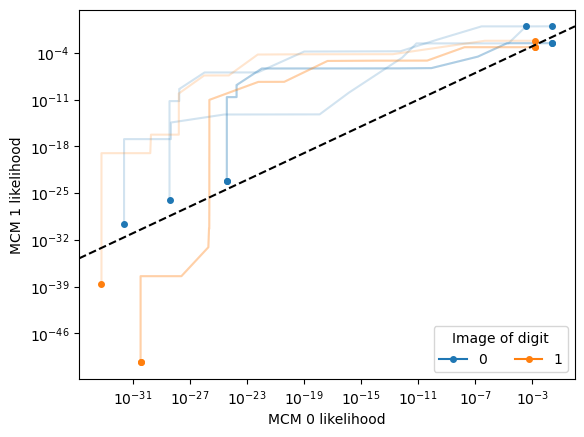

In [169]:

fig, ax1 = plt.subplots()
# axi = ax1.inset_axes([0.1, 0.7, 0.3, 0.3])

colors = myplot.get_list_fromcmap("tab10", N=10)

for dig_i, data in enumerate(all_misc): # shape each (mcm_idx, icc, image)


    # min = data.min(axis=2)[:,:,None]
    # max = data.max(axis=2)[:,:,None]
    # mean = data.mean(axis=2)[:,:,None]
    # for m in [[mean,mean], [min, max], [max, min]]:
    #     plt.plot(m[0][0, :, 0], m[1][1, :, 0], color=colors[digit_pair[dig_i]], label=f"{digit_pair[dig_i]}", alpha=.2)
    #     plt.plot(m[0][0, 0, 0], m[1][1, 0, 0], marker="o", color="black", markersize=4, label="start position")  # First point marker
    #     plt.plot(m[0][0, -1, 0], m[1][1, -1, 0], marker="o", color=colors[digit_pair[dig_i]], markersize=4,label="final position")  # Last point marker
    # -------------

    ax1.plot(data[0, :, 0], data[1, :, 0], color=colors[digit_pair[dig_i]], alpha=.2)
    ax1.plot(data[0, 0, 0], data[1, 0, 0], marker="o", color=colors[digit_pair[dig_i]], markersize=4)#, label="start position")  # First point marker
    ax1.plot(data[0, -1, 0], data[1, -1, 0], marker="o", color=colors[digit_pair[dig_i]], markersize=4,label=f"{digit_pair[dig_i]}")  # Last point marker
    for i in range(0, data.shape[2]):
        x = data[0, :, i]
        y = data[1, :, i]
        ax1.plot(x, y, color=colors[digit_pair[dig_i]], alpha=.2)
        ax1.plot(x[0], y[0], marker="o", color=colors[digit_pair[dig_i]], markersize=4)  # First point marker
        ax1.plot(x[-1], y[-1], marker="o", color=colors[digit_pair[dig_i]], markersize=4)  # Last point marker

    # inset mean CI
    # common_x, mean_y, ci_lower, ci_upper = compute_mean_and_ci_loglog(data, degree=2)
    # axi.fill_between(common_x, ci_lower, ci_upper, color=colors[digit_pair[dig_i]], alpha=0.2, label='95% CI')
    # axi.plot(common_x, mean_y, color=colors[digit_pair[dig_i]], label=f"{digit_pair[dig_i]}")
    # axi.plot([0, 1], [0, 1], color="grey", alpha=.5)  # Diagonal line
    # axi.tick_params(labelleft=False, labelbottom=False)
    # axi.set_xscale("log")
    # axi.set_yscale("log")
    # ax1.plot(common_x, mean_y, color="b" if dig_i else "g", label=f" {digit_pair[dig_i]}")




# plt.xlim([np.min(data[:,:,0]), np.max(data[:,:,0])])
# plt.ylim([np.min(data[:,:,1]), np.max(data[:,:,1])])


# m_max = np.max([np.max(all_byk_pair[i][-1,...]) for i in range(len(all_byk_pair))])
# m_min = np.min([np.min(all_byk_pair[i][-1,...]) for i in range(len(all_byk_pair))])
# plt.ylim((m_min**.8,m_max))
# plt.xlim((m_min**.8,m_max))

plt.ylabel(f"MCM {digit_pair[1]} likelihood")
plt.xlabel(f"MCM {digit_pair[0]} likelihood")
plt.legend(title="Image of digit",loc="lower right", ncol=2)
ax1.set_xscale("log")
ax1.set_yscale("log")

plt.autoscale(False)
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line

plt.show()
# plt.savefig(f"./img/misclassified_trajectory_{digit_pair[0]}{digit_pair[1]}", bbox_inches="tight",dpi=300)

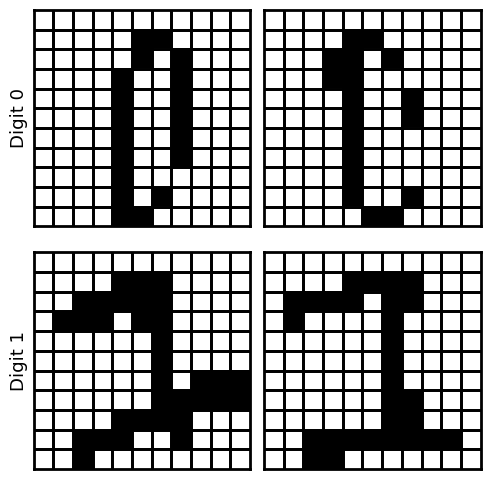

In [152]:
images = []
for i, try_dig in enumerate(digit_pair):

    # idx try dig
    test_data = utils.load_test_data(digit=try_dig)
    # misc_img = np.genfromtxt(,delimiter=1,dtype=int)
    test_data[misclf_idcs[i]]
    images.append(np.apply_along_axis(lambda x: np.genfromtxt(x, delimiter=1, dtype=int).reshape((11,11)), arr = test_data[misclf_idcs[i]], axis=1)[:2])
images = np.array(images).squeeze().reshape((-1,11,11))


fig, axs = plt.subplots(2, 2, figsize=(5, 5))
axs = axs.flatten()
for i, img in enumerate(images):

    im = myplot.partition_map(axs[i], img, None, myplot.find_borders(np.arange(121).reshape((11,11))), cbar=False, normalise=False, cmap="binary")
    if not i % 2:
        # print(i)
        axs[i].set_ylabel(f"Digit {digit_pair[i//2]}", fontsize=13)
plt.tight_layout()
plt.savefig(f"./img/misclassified_trajectory_{digit_pair[0]}{digit_pair[1]}_egdig", bbox_inches="tight",dpi=300)


(array([871.,   8.,   6.,   2.,   1.,   1.,   0.,   1.,   1.,   1.]),
 array([1.07092981e-36, 1.08543673e-13, 2.17087347e-13, 3.25631020e-13,
        4.34174693e-13, 5.42718367e-13, 6.51262040e-13, 7.59805713e-13,
        8.68349387e-13, 9.76893060e-13, 1.08543673e-12]),
 <BarContainer object of 10 artists>)

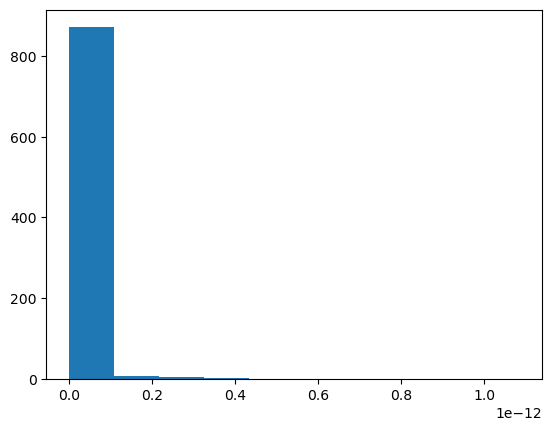

In [49]:
res = all_byk_pair[0][-1,:,0]
plt.hist(res)

In [50]:
data_max = np.max([np.max(all_byk_pair[i]) for i in range(len(all_byk_pair))])
data_min = np.min([np.min(all_byk_pair[i]) for i in range(len(all_byk_pair))])

maxs = [np.max(all_byk_pair[i]) for i in range(len(all_byk_pair))]
mins = [np.min(all_byk_pair[i]) for i in range(len(all_byk_pair))]
print(maxs,mins)

[0.11493910167772861, 0.2459468335176991] [5.4785927264051026e-42, 8.10218497475995e-102]


IndexError: index 19 is out of bounds for axis 0 with size 19

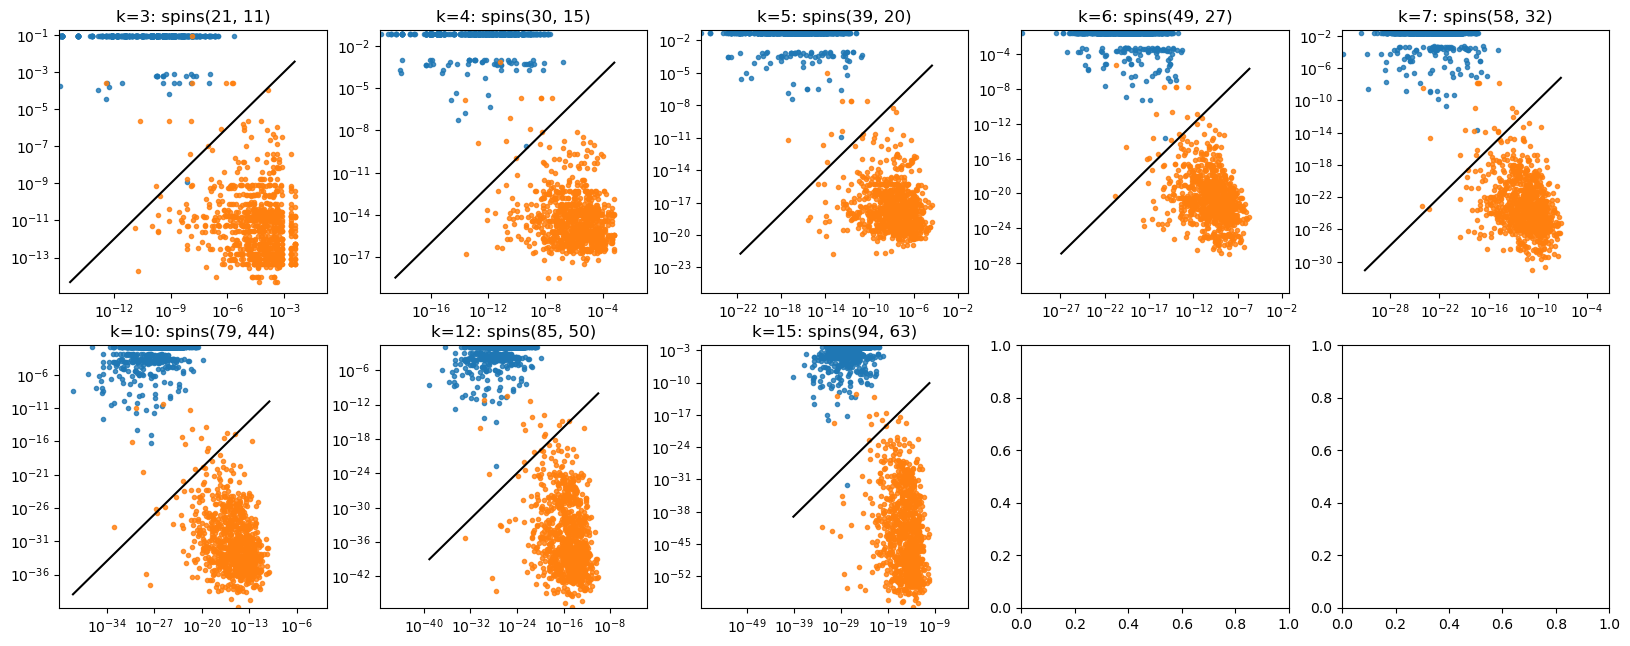

In [51]:
# take say top 5, 3 , 1 in subplots
# k = 3 e.g.,
# take top 3 k for every icc and plot histogram of test


fig, axs = plt.subplots(2,5,figsize=(20,7.5))
# fig, axs = plt.subplots(1,2,figsize=(20,7.5))

axs = axs.ravel()
# logbins = np.geomspace(data_min,data_max, 40)
len_shortest_mcm = np.min([len(i) for i in all_byk_pair])-1

top_ks = [3,4,5,6,7,
          10,12,15,20,0]
colors = myplot.get_list_fromcmap("tab10", N=10)
# top_ks = [1,4]

for j, k in enumerate(top_ks):
    ax = axs[j]

    max = np.min([np.max(all_byk_pair[i][k-1,...]) for i in range(len(all_byk_pair))])
    min = np.max([np.min(all_byk_pair[i][k-1,...]) for i in range(len(all_byk_pair))])
    
    mAsA = all_byk_pair[0][k-1,:,0]
    mAsB = all_byk_pair[0][k-1,:,1]
    mBsA = all_byk_pair[1][k-1,:,0]
    mBsB = all_byk_pair[1][k-1,:,1]
        
    ax.scatter(mAsB,mBsB, label=f"{digit_pair[1]}",alpha=.8,marker=".", color=colors[digit_pair[0]]) # data for seeing digit B
    ax.scatter(mAsA,mBsA, label=f"{digit_pair[0]}",alpha=.8,marker=".", color=colors[digit_pair[1]]) # data for seeing digit A
    ax.plot((min,max),(min,max),color="black", label="equal probability")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"k={k if k!=0 else 'all'}: spins{all_byk_modspin[0][k-1], all_byk_modspin[1][k-1]}")
    
    m_max = np.max([np.max(all_byk_pair[i][k-1,...]) for i in range(len(all_byk_pair))])
    m_min = np.min([np.min(all_byk_pair[i][k-1,...]) for i in range(len(all_byk_pair))])
    ax.set_ylim((m_min*.9,m_max*2))
    ax.set_xlim((m_min*.9,m_max*2))
    
fig.supxlabel(f"Probablity g* MCM {digit_pair[0]}")
fig.supylabel(f"Probability g* MCM {digit_pair[1]}")


plt.legend(title="Digit", bbox_to_anchor=(1.2,1,0,0))
fig.suptitle(f"K most informative icc for each MCM {digit_pair}. ICC counts: {[len(i) for i in  all_byk_modspin]}")
fig.tight_layout()

